In [119]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import seaborn as sns
pd.options.mode.chained_assignment = None 

%matplotlib inline


#read in data and see what we're working with
df = pd.read_csv("data/datasets_806447_1382162_shootings.csv")
df.describe(include = "all")

/Users/egill/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,arms_category
count,4895.000000,4895,4895,4895,4895,4895.000000,4895,4895,4895,4895,4895,4895,4895,4895,4895
unique,NaN,4851,1792,2,89,NaN,2,6,2288,51,2,3,4,2,12
top,NaN,TK TK,2018-04-01,shot,gun,NaN,M,White,Los Angeles,CA,False,attack,Not fleeing,False,Guns
freq,NaN,29,9,4647,2755,NaN,4673,2476,78,701,3792,3160,3073,4317,2764
mean,2902.148519,NaN,NaN,NaN,NaN,36.549750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,1683.467910,NaN,NaN,NaN,NaN,12.694348,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,3.000000,NaN,NaN,NaN,NaN,6.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,1441.500000,NaN,NaN,NaN,NaN,27.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,2847.000000,NaN,NaN,NaN,NaN,35.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,4352.500000,NaN,NaN,NaN,NaN,45.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
#find the percent of data that is present in each column
(df.shape[0] - df.isnull().sum())/df.shape[0] * 100

id                         100.0
name                       100.0
date                       100.0
manner_of_death            100.0
armed                      100.0
age                        100.0
gender                     100.0
race                       100.0
city                       100.0
state                      100.0
signs_of_mental_illness    100.0
threat_level               100.0
flee                       100.0
body_camera                100.0
arms_category              100.0
dtype: float64

In [9]:
#let's start by looking at geographic location
df['state'].value_counts().head()

CA    701
TX    426
FL    324
AZ    222
CO    168
Name: state, dtype: int64

In [16]:
#California has by far the most shootings.

#Does the threat level of victims play a role in their deaths?
df['threat_level'].value_counts()

attack          3160
other           1528
undetermined     207
Name: threat_level, dtype: int64

In [24]:
#Individuals who are "attacking" are about twice as likely to be shot as individuals who are not

#Let's look at the races of individuals who are shot
df['race'].value_counts()/len(df)*100

White       50.582227
Black       26.516854
Hispanic    18.426966
Asian        1.899898
Native       1.593463
Other        0.980592
Name: race, dtype: float64

In [99]:
#Individuals who are White make up about 50% of individuals who are shot, followed
#by individuals who are Black (~26%) and Hispanic (~18%)

#What about the types of weapons that victims have in their possession when they are killed?
df['armed'].value_counts()

gun                    2755
knife                   708
unknown                 418
unarmed                 348
toy weapon              171
                       ... 
air pistol                1
vehicle and machete       1
bayonet                   1
flagpole                  1
carjack                   1
Name: armed, Length: 89, dtype: int64

In [95]:
#There are 89 different types of weapons here - luckily the entries in this column have been
#grouped into 12 types.

df['arms_category'].value_counts()

Guns                     2764
Sharp objects             818
Unknown                   418
Unarmed                   348
Other unusual objects     192
Blunt instruments         122
Vehicles                  121
Multiple                   54
Piercing objects           29
Electrical devices         24
Explosives                  4
Hand tools                  1
Name: arms_category, dtype: int64

The most common weapon victims have in their possession in a gun.


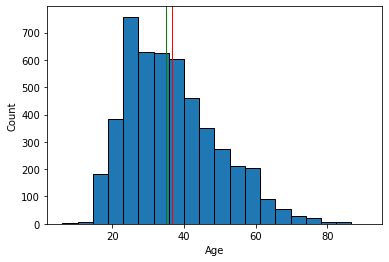

In [71]:
#I'd like to get a better look at the distribution of the age data
plt.hist(df['age'], bins=20, edgecolor="black")
plt.xlabel('Age')
plt.ylabel('Count')
#let's plot the data mean with a red line
plt.axvline(df['age'].mean(), color="red", linewidth = 1)
#and the data median with a green line
plt.axvline(df['age'].median(), color="green", linewidth = 1)

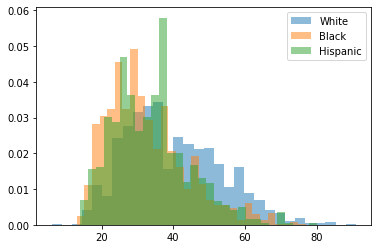

In [117]:
#Looks like the data are skewed right. Does this differ by race?
#We saw above that most victims are White, Black or Hispanic - 
#let's look at those.

#We'll plot overlapping histograms and normalize them so we can compare directly.

w_age = df[df['race'] == 'White']
b_age = df[df['race'] == 'Black']
h_age = df[df['race'] == 'Hispanic']

bins = 30

plt.hist(w_age['age'], bins, alpha=0.5, label='White', density = 1)
plt.hist(b_age['age'], bins, alpha=0.5, label='Black', density = 1)
plt.hist(h_age['age'], bins, alpha=0.5, label='Hispanic', density = 1)
plt.legend(loc='upper right')
plt.show()

These distributions don't overlap - there seem to be more Black and Hispanic victims that are younger,
and more White victims that are older.

Let's investigate which factors are associated with victims' ages in more detail.

In [104]:
#First, we'll remove 'name', 'date' and 'id' because these are unlikely to be informative
#We'll also remove 'armed' because it is co-linear with 'arms category'
#We'll remove city because this is a categorical variable that will have to be dummied and is 
#likely to have a lot of unique values. This could reduce the power of our model.
#We'll remove 'state' for now, but will investigate this further later on.

df_clean = df.drop(['name', 'date', 'id', 'city', 'armed', 'state'], axis = 1)

#Now let's dummy the the cat variables
def create_dummy_df(df, cat_cols, dummy_na):
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df

cat_df = df_clean.select_dtypes(include=['object'])
cat_cols_lst = cat_df.columns

df_new = create_dummy_df(df_clean, cat_cols_lst, dummy_na=False) 

#print(df_new.shape, df_new.head())

y = df_new['age']
X = df_new.drop(['age'], axis = 1)  


#Now we'll fit a linear model
#split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=8) 


lm_model = LinearRegression(normalize=True) 
lm_model.fit(X_train, y_train)

#evaluate model
y_train_preds = lm_model.predict(X_train)
train_score = (r2_score(y_train, y_train_preds))
    
y_test_preds = lm_model.predict(X_test) 
test_score = (r2_score(y_test, y_test_preds))
 

print(test_score, train_score)

0.09689552849917127 0.12470647907077648


Looks like our model explains about 10% of the variance in the victims' ages.

In [105]:
#Let's find out which factors have the most effect on the age at which 
#an individual is shot by police
def coef_weights(coefficients, X_train):

    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A look at the top results
coef_df

,est_int,coefs,abs_coefs
17,arms_category_Hand tools,-12.194928,12.194928
24,arms_category_Vehicles,-4.984949,4.984949
19,arms_category_Other unusual objects,-4.763851,4.763851
22,arms_category_Unarmed,-4.724257,4.724257
15,arms_category_Explosives,-4.509056,4.509056
6,race_Native,-4.316744,4.316744
18,arms_category_Multiple,-4.160925,4.160925
12,flee_Not fleeing,3.947158,3.947158
4,race_Black,-3.600369,3.600369
8,race_White,3.276002,3.276002


It looks like the type of weapon a victim has in their possession is 
correlated with their age - at the top of the list, being armed with a 
hand tool is inversely correlated with age. Being unarmed is also inversely 
correlated with age, so younger people are most likely to be shot while unarmed 
or armed with hand tools.

Age is also inversely correlated with being Native, Black, Hispanic or "Other", 
while it is positively correlated with being White. 

Individuals who are not fleeing are likely to be older.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

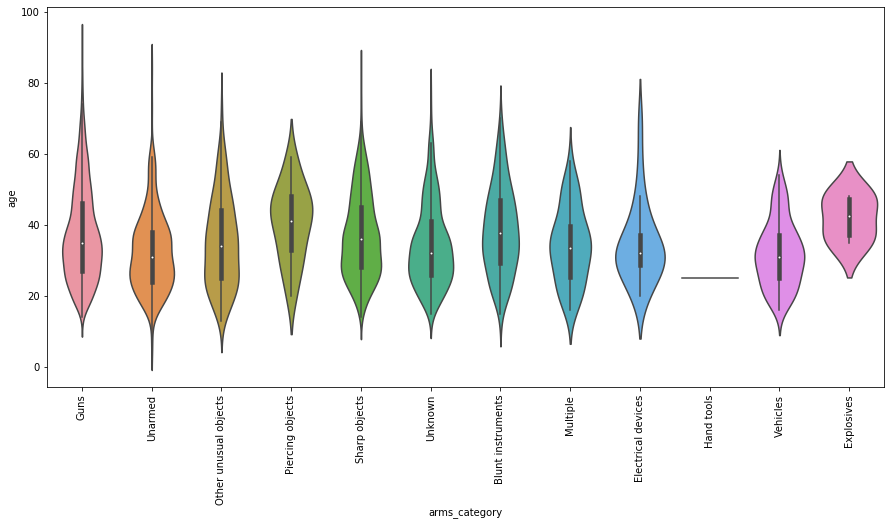

In [121]:
#Let's see if we can examine this in more detail this visually
df_plot = df_clean[['arms_category', 'age']]

fig, ax = plt.subplots(figsize = (15, 7))
sns.violinplot(x = df_plot['arms_category'], y = df_plot['age'])
plt.xticks(rotation=90)

In [123]:
#Now let's add state back into the model and see if location is correlated with
#the victims' ages

df_clean = df.drop(['name', 'date', 'id', 'city', 'armed'], axis = 1)

#Now let's dummy the the cat variables
def create_dummy_df(df, cat_cols, dummy_na):
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df

cat_df = df_clean.select_dtypes(include=['object'])
cat_cols_lst = cat_df.columns

df_new = create_dummy_df(df_clean, cat_cols_lst, dummy_na=False) 

#print(df_new.shape, df_new.head())

y = df_new['age']
X = df_new.drop(['age'], axis = 1)  


#Now we'll fit a linear model
#split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=8) 


lm_model = LinearRegression(normalize=True) 
lm_model.fit(X_train, y_train)

#evaluate model
y_train_preds = lm_model.predict(X_train)
train_score = (r2_score(y_train, y_train_preds))
    
y_test_preds = lm_model.predict(X_test) 
test_score = (r2_score(y_test, y_test_preds))
 

print(test_score, train_score)

0.09682805267143235 0.14058567811730815


In [124]:
#These r2 values are very similar to the ones we got last time, so the quality of the 
#model didn't change much.
#Let's look at the model coefficients.

coef_df = coef_weights(lm_model.coef_, X_train)

#A look at the top results
coef_df

,est_int,coefs,abs_coefs
47,state_RI,12.622271,12.622271
67,arms_category_Hand tools,-11.012161,11.012161
42,state_NY,8.155974,8.155974
15,state_DC,8.123174,8.123174
29,state_ME,6.681051,6.681051
...,...,...,...
0,signs_of_mental_illness,0.887233,0.887233
1,body_camera,-0.429803,0.429803
3,gender_M,-0.288270,0.288270
2,manner_of_death_shot and Tasered,-0.183466,0.183466


Looks like the state in which the victim is shot is indeed 
correlated with the victim's age. 

Individuals who are shot in Rhode Island, New York, the District of Columbia 
and Maine are likely to be older. It would be interesting to compare 
these results to the age distributions of the populations of these states.